### Data uploading

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leeyeji13","key":"e130cdc4520c7c2742f11ecf9ae50024"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 198MB/s]


In [4]:
!ls

kaggle.json  sample_data  womens-ecommerce-clothing-reviews.zip


In [5]:
!unzip womens-ecommerce-clothing-reviews.zip

Archive:  womens-ecommerce-clothing-reviews.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


In [6]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd

import nltk
nltk.download('stopwords')
import nltk
nltk.download('vader_lexicon')

#전처리 관련
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

#모델 관련
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#평가 관련
import datetime as dt
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Data Description

In [9]:
df =  pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col = 0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


Clothing ID - 상품번호

Age - reviewer 나이

Title - review 제목

Review Text - review

Rating - reviewr가 남긴 평가 점수

Recommended IND - reviewr가 상품에 대해 추천하는지 안하는지

Positive Feedback Count - review에 달린 긍정적인 피드백 수

Division Name - 상품이 속한 부서 이름

Department Name - 상품이 속한 부서 이름

Class Name - 상품 종류

### Data Preprocessing

In [11]:
df = df.rename(columns = {'Clothing ID' : 'Clothing_ID', 'Review Text' : 'Review_Text', 'Recommended IND' : 'Recommended_IND', 'Positive Feedback Count' : 'Positive_Feedback_Count', 'Division Name' : 'Division_Name', 'Department Name' : 'Department_Name', 'Class Name' : 'Class_Name'})
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Text Preprocessing

- 모든 구두점과 특수 문자 제거

- 대문자를 소문자로 변환

- 불용어 제거(nltk로 불용어처리를 하면 보다 정확하고 편리)

In [12]:
# Regular Expression
import re
def sentence_rge(data):
    data = re.sub('<[^>]*>','',str(data))
    data = re.sub('[\W]+',' ',data.lower())
    return data

df['Review_Text'] = df['Review_Text'].apply(sentence_rge)
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,NaN,absolutely wonderful silky and sexy and comfor...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,love this dress it s sooo pretty i happened to...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,i had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,i love love love this jumpsuit it s fun flirty...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,this shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [13]:
# Stopwords
stop_words = set(stopwords.words('english')) #패키지에 미리정의된 영어불용어를 가져옴
df['Review_Text'] = df['Review_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,NaN,absolutely wonderful silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,love dress sooo pretty happened find store gla...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,high hopes dress really wanted work initially ...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,love love love jumpsuit fun flirty fabulous ev...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,shirt flattering due adjustable front tie perf...,5,1,6,General,Tops,Blouses


### Sentiment Analysis

문맥상 의미에 따라 동일한 단어라도 완전하게 달라지기 떄문에 제공되는 감성사전은 이 문맥을 파악하는데 가장 중점을 두고 있다.  -> 감성사전을 위한 사전(NLTK, SentiWordNet, VADER, Pattern)

왜 NLTK 대신 VADER를 사용했는지?

- NLTK: 시맨틱을 프로그램적으로 인터페이스화 할 수 있게 제공. 제공되는 WordNet은 다양한 상황에서 같은 어휘라도 다르게 사용되는 어휘의 시맨틴 정보를 제공하며, 이를 위해 각각의 품사(명사, 동사, 형용사, 부사 등)로 구성된 개별 단어를 Synset이라는 개념을 이용해 표현. 하지만 예측성능은 그리 좋지 못함.

- VADER: 소설 미디어의 텍스트에 대한 감성 분석을 제공하기 위한 패키지. 비교적 빠른 수행 시간을 보장해 대용량 텍스트 데이터에 잘 사용되는 패키지로서 감성분류 문제에 있어서 높은 성능을 보여줌. 긍정, 부정, 중립 여부에 대한 각각의 확률 값을 반환하는 형태로 사용. polarity_score() 메소드를 통해 감정에 대한 평가를 확인. 'neg'는 부정 감성 지수, 'neu'는 중립적인 감성 지수, 'pos'는 긍정 감성 지수, 그리고 총 감성 지수, compound는 neg, neu, pos score를 적절히 조합해 -1에서 1사이의 감성 지수를 표현한 값. compound(총 감성 지수) 값이 사전에 설정한 임계값을 기준으로 임계값보다 높으면 긍정 감성, 낮으면 부정 감성으로 판단. 보통 임계값은 0.1로 설정하며 경우에 따라 임계값을 조정해 예측 성능을 조절.

In [14]:
# Define VADE
vader = SentimentIntensityAnalyzer()

def detect_tb_polarity(text):
    return TextBlob(text).sentiment.polarity

def detect_vader_comp(text):
    return vader.polarity_scores(text)['compound']

# Calculate Compound Score
df1 = df.copy()
df1['tb_polarity'] = df1.Review_Text.apply(detect_tb_polarity)
vader = SentimentIntensityAnalyzer()
df1['vader_comp'] = df1.Review_Text.apply(detect_vader_comp)

df1.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,tb_polarity,vader_comp
0,767,33,NaN,absolutely wonderful silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates,0.633333,0.8991
1,1080,34,NaN,love dress sooo pretty happened find store gla...,5,1,4,General,Dresses,Dresses,0.318750,0.9710
2,1077,60,Some major design flaws,high hopes dress really wanted work initially ...,3,0,0,General,Dresses,Dresses,0.082300,0.9062
3,1049,50,My favorite buy!,love love love jumpsuit fun flirty fabulous ev...,5,1,0,General Petite,Bottoms,Pants,0.500000,0.9464
4,847,47,Flattering shirt,shirt flattering due adjustable front tie perf...,5,1,6,General,Tops,Blouses,0.458333,0.9062


- 텍스트를 분류하기 위해 임계값을 0으로 설정. 복합 점수가 0보다 큰 텍스트를 긍정적인 텍스트로, 복합 점수가 0보다 작은 텍스트를 부정적인 텍스트로 할당.

In [15]:
scores = df1['vader_comp']

Label = []
length = len(scores)
for i in range(length):
   Score = scores[i]
   if Score >= 0: # Positive Text
       Label.append(1)
   else:
       Label.append(0) # Negative Text

In [16]:
df1['Label'] = Label
df1.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,tb_polarity,vader_comp,Label
0,767,33,NaN,absolutely wonderful silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates,0.633333,0.8991,1
1,1080,34,NaN,love dress sooo pretty happened find store gla...,5,1,4,General,Dresses,Dresses,0.318750,0.9710,1
2,1077,60,Some major design flaws,high hopes dress really wanted work initially ...,3,0,0,General,Dresses,Dresses,0.082300,0.9062,1
3,1049,50,My favorite buy!,love love love jumpsuit fun flirty fabulous ev...,5,1,0,General Petite,Bottoms,Pants,0.500000,0.9464,1
4,847,47,Flattering shirt,shirt flattering due adjustable front tie perf...,5,1,6,General,Tops,Blouses,0.458333,0.9062,1


In [17]:
df2 = df1[['Review_Text', 'Label']]
df2.head()

,Review_Text,Label
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store gla...,1
2,high hopes dress really wanted work initially ...,1
3,love love love jumpsuit fun flirty fabulous ev...,1
4,shirt flattering due adjustable front tie perf...,1


In [18]:
# Update Stopword
df3 = df2.copy()
stop_words.update(['nan', 'dress', 'shirt', 's', 'm', 'top', 'color', 'bought', 'look', 'ordered'])
df3['Review_Text'] = df3['Review_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df3.head()

,Review_Text,Label
0,absolutely wonderful silky sexy comfortable,1
1,love sooo pretty happened find store glad bc n...,1
2,high hopes really wanted work initially petite...,1
3,love love love jumpsuit fun flirty fabulous ev...,1
4,flattering due adjustable front tie perfect le...,1


Positive words are as follows


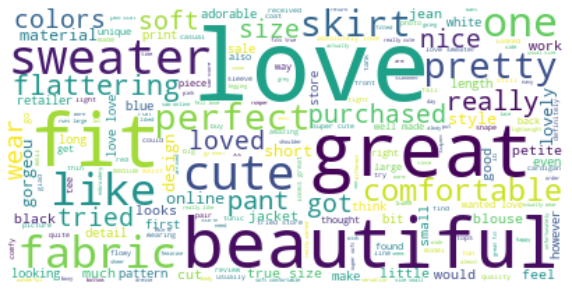

Negative words are as follows


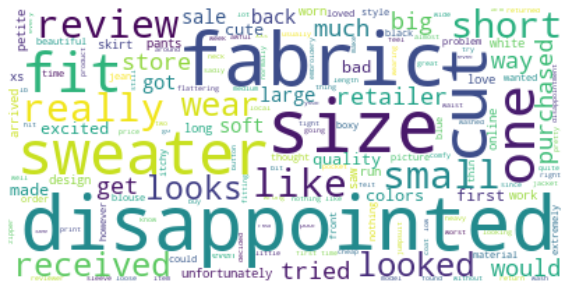

In [19]:
# Word Cloud
Positive_Data = df3[df3["Label"] == 1]
Positive_Data = Positive_Data["Review_Text"]
Negative_Data = df3[df3["Label"] == 0]
Negative_Data = Negative_Data["Review_Text"] 

# Convert Data to String
Positive_Data_2 = Positive_Data.to_string()
Negative_Data_2 = Negative_Data.to_string()

print("Positive words are as follows")
Wordcloud_P = WordCloud(stopwords=stop_words, background_color='white').generate(Positive_Data_2)
plt.figure(figsize=(10,10))
plt.imshow(Wordcloud_P, interpolation='bilinear')
plt.axis("off")
plt.show() 

print("Negative words are as follows")
Wordcloud_N = WordCloud(stopwords=stop_words, background_color='white').generate(Negative_Data_2)
plt.figure(figsize=(10,10))
plt.imshow(Wordcloud_N, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modeling

- train/test로 분리

- 텍스트 data('Review_Text')를 numeric으로 변환(모델의 학습 위해)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df3['Review_Text'], df3['Label'], train_size = 0.8, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18788,), (4698,), (18788,), (4698,))

In [21]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train.values.ravel())
X_train = vectorizer.transform(X_train.values.ravel())
X_test = vectorizer.transform(X_test.values.ravel())
X_train = X_train.toarray()
X_test = X_test.toarray()

In [22]:
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12748,12749,12750,12751,12752,12753,12754,12755,12756,12757
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- 1(positive) -> 22873, 0(negative) -> 613 => 클래스 불균형

- 클래스 불균형 문제 해결 => SMOTE 방식 사용(negative 클래스를 oversample 하는 방법) => 

SMOTE?
- 클래스 불균형 해결 방법 중 하나
- 언더/오버 샘플링은 반드시 Train 데이터에만 적용
- 오버 샘플링? 불균형한 데이터셋에서 낮은 비율을 차지하던 클래스의 데이터 수를 늘림 => 존재하지 않는 데이터의 수를 늘리는 과정에서 과적합을 야기하여 성능을 저하할 수 있음.(알고리즘 기반으로 데이터를 생성하다보니 과적합 발생 가능성이 단순 무작위 방법보다 적음.)

In [23]:
# X_train_sm, Y_train_sm = SMOTE(random_state = 0).fit_resample(X_train, y_train)
# X_train_sm.shape, Y_train_sm.shape

### Building sentiment classifiers

- Logistic Regression : 이진 분류에 대한 가장 간단한 기술 중 하나

- Naive Bayes : 다양한 속성을 기반으로 서로 다른 클래스의 확률을 예측하는 분류 알고리즘 모음

- Random Forest : 결정 트리로 구성된 앙상블 학습 방법

- Support Vector Machine : 회귀 또는 분류 문제에 대한 지도 학습 알고리즘

Logistic Regression

In [24]:
start = dt.datetime.now()
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now() - start))
y_pred = lr.predict(X_test)
lr_as = accuracy_score(y_test, y_pred)
lr_rs = recall_score(y_test, y_pred, average = "weighted")
lr_fs = f1_score(y_test, y_pred, average = "weighted")
print("Accuracy: " + str(lr_as))
print("Recall: " + str(lr_rs))
print("F1-Score: " + str(lr_fs))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1])  
auc_lr = metrics.roc_auc_score(y_test, lr.predict(X_test))

Elapsed time:  0:00:23.939605
Accuracy: 0.9774372073222648
Recall: 0.9774372073222648
F1-Score: 0.9728028218115905
Confusion Matrix
[[  33   89]
 [  17 4559]]
              precision    recall  f1-score   support

           0       0.66      0.27      0.38       122
           1       0.98      1.00      0.99      4576

    accuracy                           0.98      4698
   macro avg       0.82      0.63      0.69      4698
weighted avg       0.97      0.98      0.97      4698



Naive Bayes

In [25]:
start = dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now() - start))
y_pred = nb.predict(X_test)
nb_as = accuracy_score(y_test, y_pred)
nb_rs = recall_score(y_test, y_pred, average = "weighted")
nb_fs = f1_score(y_test, y_pred, average = "weighted")
print("Accuracy: " + str(nb_as))
print("Recall: " + str(nb_rs))
print("F1-Score: " + str(nb_fs))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, nb.predict_proba(X_test)[:,1])  
auc_nb = metrics.roc_auc_score(y_test, nb.predict(X_test))

Elapsed time:  0:00:09.794649
Accuracy: 0.9742443593018306
Recall: 0.9742443593018306
F1-Score: 0.9639982809668565
Confusion Matrix
[[   7  115]
 [   6 4570]]
              precision    recall  f1-score   support

           0       0.54      0.06      0.10       122
           1       0.98      1.00      0.99      4576

    accuracy                           0.97      4698
   macro avg       0.76      0.53      0.55      4698
weighted avg       0.96      0.97      0.96      4698



Random Forest

In [26]:
start = dt.datetime.now()
rfc = RandomForestClassifier(max_depth = 13, random_state=0)
rfc.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now() - start))
y_pred = rfc.predict(X_test)
rfc_as = accuracy_score(y_test, y_pred)
rfc_rs = recall_score(y_test, y_pred, average = "weighted")
rfc_fs = f1_score(y_test, y_pred, average = "weighted")
print("Accuracy: " + str(rfc_as))
print("Recall: " + str(rfc_rs))
print("F1-Score: " + str(rfc_fs))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
fpr_rfc, tpr_rfc, thresholds_rfc = metrics.roc_curve(y_test, rfc.predict_proba(X_test)[:,1])  
auc_rfc = metrics.roc_auc_score(y_test, rfc.predict(X_test))

Elapsed time:  0:00:22.494082
Accuracy: 0.9740315027671349
Recall: 0.9740315027671349
F1-Score: 0.9612180626832887
Confusion Matrix
[[   0  122]
 [   0 4576]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.97      1.00      0.99      4576

    accuracy                           0.97      4698
   macro avg       0.49      0.50      0.49      4698
weighted avg       0.95      0.97      0.96      4698



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine

In [27]:
start = dt.datetime.now()
svm = SVC()
svm.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now() - start))
y_pred = svm.predict(X_test)
svm_as = accuracy_score(y_test, y_pred)
svm_rs = recall_score(y_test, y_pred, average = "weighted")
svm_fs = f1_score(y_test, y_pred, average = "weighted")
print("Accuracy: " + str(svm_as))
print("Recall: " + str(svm_rs))
print("F1-Score: " + str(svm_fs))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, svm.decision_function(X_test))  
auc_svm = metrics.roc_auc_score(y_test, svm.predict(X_test))

Elapsed time:  0:16:31.973639
Accuracy: 0.9742443593018306
Recall: 0.9742443593018306
F1-Score: 0.961743972393524
Confusion Matrix
[[   1  121]
 [   0 4576]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       122
           1       0.97      1.00      0.99      4576

    accuracy                           0.97      4698
   macro avg       0.99      0.50      0.50      4698
weighted avg       0.97      0.97      0.96      4698



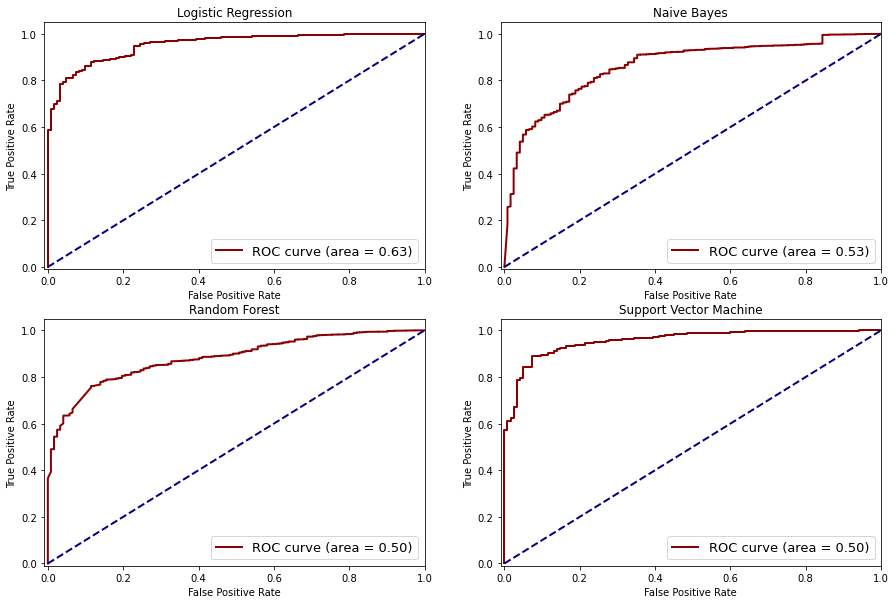

In [28]:
f, axes = plt.subplots(2, 2,figsize=(15,10))
axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_rfc, tpr_rfc, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(auc_rfc))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest')
axes[1,0].legend(loc='lower right', fontsize=13);

axes[1,1].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(auc_svm))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,1].legend(loc='lower right', fontsize=13)

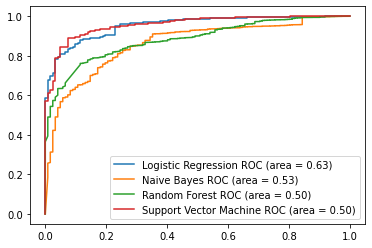

In [29]:
plt.figure(0).clf()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression ROC (area = %.2f)' % (auc_lr))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes ROC (area = %.2f)' % (auc_nb))
plt.plot(fpr_rfc, tpr_rfc, label='Random Forest ROC (area = %.2f)' % (auc_rfc))
plt.plot(fpr_svm, tpr_svm, label='Support Vector Machine ROC (area = %.2f)' % (auc_svm))
plt.legend()